<a href="https://colab.research.google.com/github/HastingsGreer/SemiSupervisedSequence/blob/master/Downstream_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Movies_and_TV_5.json.gz

--2022-08-25 08:38:41--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Movies_and_TV_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791322468 (755M) [application/octet-stream]
Saving to: ‘Movies_and_TV_5.json.gz’

Movies_and_TV_5.jso 100%[===================>] 754.66M  44.5MB/s    in 33s     

2022-08-25 08:39:21 (22.8 MB/s) - ‘Movies_and_TV_5.json.gz’ saved [791322468/791322468]



In [ ]:
#!gunzip Movies_and_TV_5.json.gz

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,"

In [ ]:
import json
text = []
scores = []
with open("Movies_and_TV_5.json", "r") as f:
  for l in f.readlines():
    d = json.loads(l)
    if "reviewText" in d:
      text.append(d["reviewText"])
      scores.append(d["overall"])

In [ ]:
len(text)
import random
random.shuffle(text)

In [ ]:
pip install --quiet transformers

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import AutoTokenizer
from transformers import PreTrainedTokenizerFast
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
def tokens(k):
  text_tok = tokenizer(text[10000 * k:10000 * (k + 1)], padding=True, truncation=True, return_tensors="pt")
  text_tok = text_tok['input_ids']
  text_tok = text_tok[:, :128]
  return text_tok

In [ ]:
import torch

In [ ]:
class SimpleLanguageModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = torch.nn.Embedding(num_embeddings=30522, embedding_dim=256)
    #self.inlayer = torch.nn.LSTM(input_size=256, hidden_size=1024, num_layers=2, batch_first=True)
    self.outlayer = torch.nn.LSTM(input_size=256, hidden_size=1024, num_layers=2, batch_first=True)
    self.output = torch.nn.Conv1d(in_channels=1024, out_channels = 256, kernel_size=1)
    self.output2 = torch.nn.Conv1d(in_channels=256, out_channels = 30522, kernel_size=1)

  def forward(self, input):
    input = self.embedding(input)

    #repr = self.inlayer(torch.flip(input, dims=(1,)))[1]
    repr = self.outlayer(input)
    repr = repr[0]
    
    repr = torch.transpose(repr, 1, 2)
    out = self.output2(self.output(repr))
    return out

m = SimpleLanguageModel()
m.cuda()

SimpleLanguageModel(
  (embedding): Embedding(30522, 256)
  (outlayer): LSTM(256, 1024, num_layers=2, batch_first=True)
  (output): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
  (output2): Conv1d(256, 30522, kernel_size=(1,), stride=(1,))
)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=.0001)
curve = []

In [ ]:
for k in range(300):
  text_tok = tokens(k)
  for _ in range(10):
    for _ in range(10):
      optimizer.zero_grad()
      idxs = torch.randint(0, 10000, (64,))
      input_ = text_tok[idxs].cuda()

      outputs = m(input_)

      l = loss(outputs[:, :, :-1], input_[:, 1:])
      l.backward()
      optimizer.step()
      curve.append(l.item())
    print(torch.mean(torch.tensor(curve[-10:])))

tensor(9.5885)
tensor(4.8849)
tensor(4.0974)
tensor(4.4246)
tensor(4.0142)
tensor(4.1544)
tensor(3.9251)
tensor(3.5031)
tensor(3.2331)
tensor(2.9306)
tensor(2.9361)
tensor(2.5328)
tensor(2.5729)
tensor(2.8169)
tensor(2.5461)
tensor(2.8465)
tensor(2.9052)
tensor(2.7042)
tensor(2.5802)
tensor(2.7994)
tensor(2.7573)
tensor(2.7197)
tensor(2.7479)
tensor(2.7800)
tensor(2.7017)
tensor(2.5996)
tensor(2.6789)
tensor(2.8174)
tensor(2.4147)
tensor(2.7151)
tensor(2.7144)
tensor(2.8065)
tensor(2.6285)
tensor(2.6171)
tensor(2.5748)
tensor(2.6258)
tensor(2.5919)
tensor(2.6963)
tensor(2.5581)
tensor(2.7288)
tensor(2.7197)
tensor(2.4885)
tensor(2.5556)
tensor(2.4802)
tensor(2.5419)
tensor(2.7038)
tensor(2.6030)
tensor(2.6393)
tensor(2.6083)
tensor(2.6457)
tensor(2.5048)
tensor(2.6162)
tensor(2.6789)
tensor(2.6153)
tensor(2.5179)
tensor(2.7737)
tensor(2.5364)
tensor(2.7445)
tensor(2.6021)
tensor(2.4798)
tensor(2.6898)
tensor(2.6268)
tensor(2.6861)
tensor(2.7053)
tensor(2.4771)
tensor(2.5528)
tensor(2.4

tensor(2.0010)
tensor(2.0934)
tensor(2.0621)
tensor(2.0705)
tensor(1.9810)
tensor(2.0314)
tensor(2.1643)
tensor(1.9579)
tensor(2.1276)
tensor(2.0183)
tensor(1.9644)
tensor(2.0890)
tensor(2.0079)
tensor(2.0611)
tensor(2.0784)
tensor(1.9792)
tensor(2.0936)
tensor(2.2629)
tensor(2.0122)
tensor(1.8905)
tensor(2.0805)
tensor(1.9888)
tensor(1.7931)
tensor(1.9340)
tensor(2.0058)
tensor(2.0009)
tensor(2.0599)
tensor(1.8966)
tensor(1.9531)
tensor(2.1940)
tensor(2.0450)
tensor(2.1102)
tensor(2.0882)
tensor(2.0641)
tensor(1.9490)
tensor(1.9904)
tensor(2.0465)
tensor(1.9587)
tensor(1.9937)
tensor(2.0291)
tensor(1.9809)
tensor(1.9569)
tensor(1.9524)
tensor(1.9501)
tensor(1.9166)
tensor(1.9467)
tensor(1.8752)
tensor(1.9491)
tensor(1.9653)
tensor(1.8708)
tensor(1.9036)
tensor(2.0446)
tensor(1.9462)
tensor(2.0213)
tensor(2.1057)
tensor(2.0914)
tensor(2.0697)
tensor(1.9779)
tensor(1.9299)
tensor(2.1355)
tensor(1.8752)
tensor(1.9933)
tensor(1.9760)
tensor(1.9145)
tensor(1.9370)
tensor(1.9786)
tensor(1.9

tensor(1.8643)
tensor(1.8438)
tensor(1.8474)
tensor(1.8433)
tensor(1.9078)
tensor(1.7241)
tensor(1.8676)
tensor(1.8408)
tensor(1.9378)
tensor(1.8745)
tensor(1.8297)
tensor(1.9771)
tensor(1.9699)
tensor(1.8081)
tensor(1.9473)
tensor(1.9128)
tensor(1.7376)
tensor(1.8274)
tensor(1.7339)
tensor(1.8053)
tensor(1.9004)
tensor(1.8288)
tensor(1.8604)
tensor(1.7747)
tensor(1.8539)
tensor(1.6813)
tensor(1.7908)
tensor(1.9649)
tensor(1.8717)
tensor(1.9331)
tensor(1.9080)
tensor(1.8532)
tensor(1.8458)
tensor(1.7143)
tensor(1.8757)
tensor(1.7603)
tensor(2.0217)
tensor(1.7925)
tensor(2.0188)
tensor(1.9735)
tensor(1.8037)
tensor(1.8428)
tensor(1.7417)
tensor(1.8679)
tensor(1.8099)
tensor(1.8591)
tensor(1.9083)
tensor(1.7640)
tensor(1.8258)
tensor(1.8805)
tensor(1.9402)
tensor(1.9332)
tensor(1.8493)
tensor(1.8895)
tensor(1.9749)
tensor(1.9527)
tensor(1.8532)
tensor(2.1131)
tensor(1.8487)
tensor(1.8071)
tensor(1.8997)
tensor(1.9380)
tensor(1.8551)
tensor(1.8726)
tensor(1.7971)
tensor(1.8456)
tensor(1.7

tensor(1.8524)
tensor(1.9895)
tensor(1.8985)
tensor(1.7707)
tensor(1.8609)
tensor(1.8781)
tensor(1.8878)
tensor(1.8664)
tensor(1.8066)
tensor(1.7168)
tensor(1.7637)
tensor(1.7383)
tensor(1.9255)
tensor(1.7460)
tensor(1.8998)
tensor(1.7692)
tensor(1.7648)
tensor(1.6657)
tensor(1.8993)
tensor(1.9039)
tensor(1.8405)
tensor(1.6999)
tensor(1.8644)
tensor(1.7173)
tensor(1.8220)
tensor(1.8161)
tensor(1.9555)
tensor(1.7903)
tensor(1.9269)
tensor(1.7675)
tensor(1.8421)
tensor(2.0155)
tensor(1.6961)
tensor(1.8429)
tensor(1.9403)
tensor(1.7179)
tensor(1.6999)
tensor(1.7819)
tensor(1.8035)
tensor(1.6576)
tensor(1.6431)
tensor(1.7543)
tensor(1.8070)
tensor(1.6951)
tensor(1.8329)
tensor(1.6652)
tensor(1.6322)
tensor(1.8614)
tensor(1.7603)
tensor(1.8116)
tensor(1.7858)
tensor(1.7125)
tensor(1.7409)
tensor(1.7553)
tensor(1.8722)
tensor(1.8121)
tensor(1.8018)
tensor(1.8810)
tensor(1.7734)
tensor(1.7518)
tensor(1.9349)
tensor(1.7766)
tensor(1.7364)
tensor(1.9517)
tensor(1.8600)
tensor(1.8031)
tensor(1.6

tensor(1.7210)
tensor(1.6133)
tensor(1.6510)
tensor(1.7308)
tensor(1.7287)
tensor(1.6743)
tensor(1.7096)
tensor(1.7351)
tensor(1.7885)
tensor(1.7712)
tensor(1.7066)
tensor(1.7880)
tensor(1.6683)
tensor(1.6666)
tensor(1.7540)
tensor(1.6095)
tensor(1.7602)
tensor(1.6214)
tensor(1.8050)
tensor(1.8975)
tensor(1.6736)
tensor(1.7387)
tensor(1.8834)
tensor(1.8007)
tensor(1.8017)
tensor(1.8021)
tensor(1.7691)
tensor(1.7578)
tensor(1.5985)
tensor(1.7369)
tensor(1.9110)
tensor(1.7549)
tensor(1.8171)
tensor(1.8313)
tensor(1.6065)
tensor(1.9144)
tensor(1.7864)
tensor(1.7045)
tensor(1.6545)
tensor(1.7643)
tensor(1.9118)
tensor(1.6843)
tensor(1.7431)
tensor(1.8414)
tensor(1.7965)
tensor(1.6439)
tensor(1.7265)
tensor(1.6815)
tensor(1.8076)
tensor(1.7527)
tensor(1.7555)
tensor(1.6067)
tensor(1.7028)
tensor(1.8237)
tensor(1.8664)
tensor(1.5916)
tensor(1.8857)
tensor(1.7905)
tensor(1.7962)
tensor(1.8895)
tensor(1.9071)
tensor(1.7826)
tensor(1.7660)
tensor(1.7559)
tensor(1.6536)
tensor(1.7754)
tensor(1.8

tensor(1.6815)
tensor(1.6552)
tensor(1.7775)
tensor(1.7601)
tensor(1.7916)
tensor(1.6771)
tensor(1.9119)
tensor(1.7612)
tensor(1.7616)
tensor(1.8264)
tensor(1.6709)
tensor(1.7509)
tensor(1.7944)
tensor(1.7687)
tensor(1.6664)
tensor(1.7051)
tensor(1.6277)
tensor(1.6839)
tensor(1.7622)
tensor(1.7096)
tensor(1.7026)
tensor(1.7960)
tensor(1.7190)
tensor(1.6303)
tensor(1.6801)
tensor(1.8125)
tensor(1.6548)
tensor(1.7197)
tensor(1.6410)
tensor(1.7405)
tensor(1.6429)
tensor(1.6364)
tensor(1.6115)
tensor(1.7864)
tensor(1.6285)
tensor(1.7412)
tensor(1.7790)
tensor(1.6859)
tensor(1.7300)
tensor(1.7264)
tensor(1.5273)
tensor(1.6367)
tensor(1.6990)
tensor(1.7151)
tensor(1.7164)
tensor(1.6627)
tensor(1.7999)
tensor(1.7589)
tensor(1.7168)
tensor(1.7616)
tensor(1.5732)
tensor(1.6175)
tensor(1.7608)
tensor(1.6658)
tensor(1.7298)
tensor(1.6093)
tensor(1.6939)
tensor(1.7303)
tensor(1.7434)
tensor(1.6319)
tensor(1.6637)
tensor(1.6703)
tensor(1.7554)
tensor(1.6178)
tensor(1.6942)
tensor(1.7924)
tensor(1.7

In [ ]:
k

299

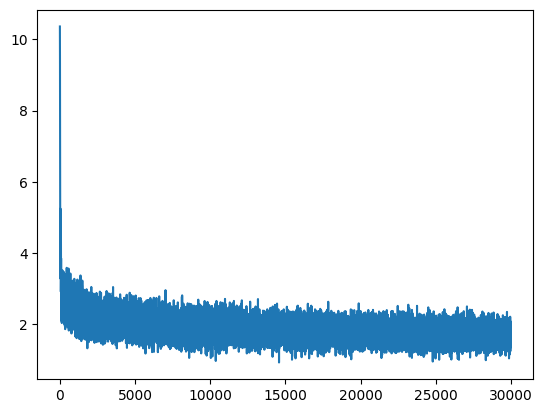

In [ ]:
import matplotlib.pyplot as plt
plt.plot(curve)

In [ ]:
tokenizer.decode(input_[46])

'[CLS] at the time this show was on i was on active duty with the navy so i did not not get to see it very often. while on a port visit to san francisco we were able to see the filming of an episode and the producers ( star don johnson was one of them ) arranged for three of the bright yellow " hemi cudas used for the show to be hands on for pictures with crewmembers. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
tokenizer.decode(torch.argmax(outputs[46], axis=0))

'i first end of movie was a tv was a the and and the first and i was not know know to see it. much. i i the saturday\'to the francisco, have able to get the show of the old of the first of the trek\') a of the ). to the years the best tv and thesworth "shing " " the show " be " down the the. the. ons. " [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
import footsteps
torch.save(m.state_dict(), footsteps.output_dir + "weights.pth")
torch.save(curve, footsteps.output_dir + 'learning curve')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Input name of experiment:
predictive_lstm
Saving results to results/predictive_lstm/
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the en